In [176]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#helper functions
def int2analog(x, n=10):
    # Convert an integer to a PyTorch tensor
    x_tensor = torch.tensor([x], dtype=torch.int32)

    # Convert integers into the corresponding binary bits.
    shifts = torch.arange(n - 1, -1, -1, dtype=x_tensor.dtype)
    x_tensor = torch.bitwise_right_shift(x_tensor, shifts)
    x_tensor = torch.remainder(x_tensor, 2)

    # Convert the binary bits into the corresponding analog values.
    x_tensor = x_tensor.type(torch.float32)
    x_tensor = 2 * x_tensor - 1


    return x_tensor  

def analog2int(x):
    # Convert an analog bit representation back to an integer
    x = (x + 1) / 2  # Convert from [-1, 1] to [0, 1]
    x = torch.round(x).type(torch.int32)  # Round and convert to int
    # Convert binary bits back to integer
    int_val = 0
    for i, bit in enumerate(reversed(x)):
        int_val += bit.item() * (2 ** i)
    return int_val


## Dataset Generation for Binary Sequences Toy Example
The dataset is designed to consist of binary sequences with a specific structure and controlled noise. It's generated using the generate_binary_dataset function, which allows for customization in terms of size, noise levels, and dataset splits.

Structure of the Sequences
The core of the dataset comprises two types of binary sequences:

#### 11110000
#### 00001111
Each sequence is an 8-bit binary pattern, with the first type having the first four bits set to 1 and the last four to 0, and the second type being its inverse.

Noise Introduction
Noise is introduced to these sequences to simulate real-world imperfections or variations. The level and probability of noise can be adjusted:

Noise Level (noise_level): Determines the number of bits to flip in each sequence. This is capped at 8, the length of the sequences.
Noise Probability (noise_prob): The likelihood of any bit being flipped in a sequence.
This mechanism ensures that the dataset doesn't just contain pristine, predictable patterns, but rather includes realistic variations

In [177]:
import numpy as np
import random

def generate_binary_dataset(size, noise_level=1, noise_prob=0.2, train_split=0.7, test_split=0.3, validation_split=0):
    """
    Generates a dataset with binary sequences "11110000" and "00001111", 
    with a specified level of noise and splits it into training, testing,
    and optionally validation sets.

    Args:
    - size (int): Number of samples to generate.
    - noise_level (int): Number of bits to flip for adding noise.
    - noise_prob (float): Probability of flipping a bit.
    - train_split (float): Fraction of the dataset to be used for training.
    - test_split (float): Fraction of the dataset to be used for testing.
    - validation_split (float): Fraction of the dataset to be used for validation.

    Returns:
    - tuple of torch.Tensors: (train_set, test_set, validation_set)
    """

    if train_split + test_split + validation_split > 1:
        raise ValueError("Sum of splits must not exceed 1.")

    # Two base patterns
    pattern1 = np.array([1, 1, 1, 1, 0, 0, 0, 0])
    pattern2 = np.array([0, 0, 0, 0, 1, 1, 1, 1])

    # Initialize dataset
    dataset = np.zeros((size, 8), dtype=int)

    for i in range(size):
        # Choose a base pattern for each sample
        pattern = pattern1 if np.random.rand() > 0.5 else pattern2

        # Add noise by flipping 'noise_level' number of bits
        if (noise_level > 8):
            raise ValueError("noise_level must be less than or equal to 8.")
        if (noise_level < 0):
            raise ValueError("noise_level must be greater than or equal to 0.")

        noisy_pattern = pattern.copy()
        if (random.random() < noise_prob):
            noise_indices = np.random.choice(8, noise_level, replace=False)
            noisy_pattern[noise_indices] = 1 - noisy_pattern[noise_indices]
            
        dataset[i] = noisy_pattern

    # Split dataset into training, testing, and validation sets
     # Convert dataset to a PyTorch tensor
    dataset = torch.tensor(dataset)

    # Calculate split sizes
    train_size = int(size * train_split)
    test_size = int(size * test_split)
    validation_size = size - train_size - test_size

    # Split the dataset
    train_set = dataset[:train_size]
    test_set = dataset[train_size:train_size + test_size]
    validation_set = dataset[train_size + test_size:] if validation_split > 0 else None

    return train_set, test_set, validation_set

#### Dataset Demonstration

In [178]:
# Generate a dataset with 1000 samples and noise prob 0.2
train_set, test_set, validation_set = generate_binary_dataset(10000, noise_prob=0.0)

print("Shape of train_set:", train_set.shape)
print("Shape of test_set:", test_set.shape)

# Print the first 10 samples of the training set
print("First 5 samples of the training set:")
print(train_set[:5])

Shape of train_set: torch.Size([7000, 8])
Shape of test_set: torch.Size([3000, 8])
First 5 samples of the training set:
tensor([[0, 0, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0]])


In [179]:
def byte2analog(x):
    """
    Converts a byte to an analog signal.

    Args:
    - x (torch.Tensor): A tensor of shape (8,) representing a byte.

    Returns:
    - torch.Tensor: A tensor of shape (8,) representing an analog signal.
    """

    # Convert to float
    x = x.float()

    # Scale to [-1, 1]
    x = 2 * x - 1

    return x
    

### Corruption Process and Noise Schedule

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. To save time, there is a faster formula that computes all the timesteps simultaneously: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>


In [180]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Generates a cosine noise schedule.

    Args:
    - timesteps (int): The total number of timesteps.
    - s (float): Scale factor for the noise level.

    Returns:
    - torch.Tensor: The beta schedule tensor.
    """
    steps = torch.arange(timesteps, dtype=torch.float32) / timesteps
    beta_schedule = s * (1 + torch.cos(torch.pi * steps)) / 2
    return beta_schedule

def compute_alpha_bar(beta_schedule):
    alpha = 1. - beta_schedule
    alpha_bar = torch.cumprod(alpha, dim=0)
    return alpha, alpha_bar

def apply_noise(x, timestep, beta_schedule):
    """
    Applies noise to an image x at a specific timestep.

    Args:
    - x (torch.Tensor): The initial image tensor.
    - timestep (int): The specific timestep at which to apply noise.
    - beta_schedule (torch.Tensor): The beta schedule tensor.

    Returns:
    - torch.Tensor: The noised version of the image at the specified timestep.
    """
    # Compute alpha and alpha_bar
    alpha, alpha_bar = compute_alpha_bar(beta_schedule)

    # Ensure the timestep is within the range of the beta schedule
    if timestep >= beta_schedule.size(0):
        raise ValueError("Timestep is out of range of the beta schedule")

    # Add noise to the image at the specified timestep
    epsilon = torch.randn_like(x)
    xt = torch.sqrt(alpha_bar[timestep]) * x + torch.sqrt(1. - alpha_bar[timestep]) * epsilon

    return xt

# Example usage
T = 1000  # Number of timesteps
beta_schedule = torch.linspace(1e-4, 0.02, T)  # Example beta schedule
x0 = torch.tensor([1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0])

# Apply noise recurseively for T timesteps
x_to_plot = []
xt = x0
for t in range(T):
    xt = apply_noise(xt, t, beta_schedule)
    if t % 100 == 0:
        print("Timestep:", t, end=" | ")
        print("xt:", xt)
        x_to_plot.append(xt)




Timestep: 0 | xt: tensor([ 0.9985, -0.9959, -0.9915, -1.0002, -0.9991, -0.9972, -0.9829,  0.9862])
Timestep: 100 | xt: tensor([-0.4773,  0.5148,  1.6576,  1.9752, -1.3066, -0.6757, -0.1901, -0.2499])
Timestep: 200 | xt: tensor([ 0.3423, -0.4612,  1.0603,  0.4100,  0.0493,  0.1331,  0.2730,  1.0879])
Timestep: 300 | xt: tensor([ 0.2423,  2.2476,  2.2598,  1.1733, -0.5352, -0.0495, -0.8379, -0.2661])
Timestep: 400 | xt: tensor([ 2.8440, -0.6007, -0.9236, -0.2528,  0.0985,  0.2645, -1.1408, -1.2446])
Timestep: 500 | xt: tensor([-2.2803,  1.0438,  0.1974, -1.2153,  1.9033, -0.6324,  0.1402, -0.3827])
Timestep: 600 | xt: tensor([ 0.5831, -1.2246, -0.5975, -1.2216, -2.0222, -0.9437, -1.0224, -0.5913])
Timestep: 700 | xt: tensor([-0.3372,  0.5622,  1.2552, -0.9852, -0.4325, -0.8994, -0.2007,  0.0053])
Timestep: 800 | xt: tensor([ 0.0177,  0.4739, -1.6318, -0.7303, -1.0310, -0.7957, -0.3084, -0.3983])
Timestep: 900 | xt: tensor([ 0.3084, -0.2993, -0.5409,  1.0397, -0.3876, -0.2007, -1.4607,  0

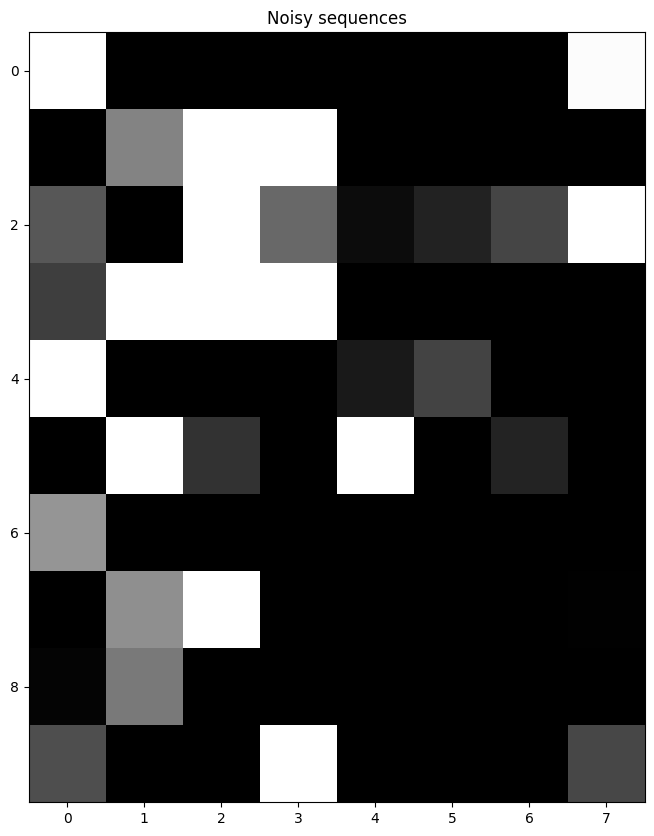

In [181]:
#visualize sequence as image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def visualize_sequence(sequence, title=""):
    """
    Visualizes a sequence as an image.

    Args:
    - sequence (torch.Tensor): A tensor of shape (8,) representing a sequence.
    - title (str): Title of the image.
    """

    # Convert sequence to a numpy array
    if isinstance(sequence, torch.Tensor):
        sequence = sequence.cpu().detach().numpy()


    # Reshape sequence to (1, 8) and transpose it to (8, 1)
    sequence = sequence.reshape((8, 1)).T

    # Map noisy sequences from [-1, 1] to [0, 1] and clip
    sequence = np.clip(sequence, -1, 1)

    # Plot the noisy sequences
    plt.figure(figsize=(8, 1))
    plt.imshow(sequence, cmap="gray", vmin=0, vmax=1)
    plt.title(title)
    plt.show()


# Example
#visualize_sequence(x0, title="x0")

#visualize 10 noisy sequences in a grid
def visualize_noisy_sequences(noisy_sequences, title=""):
    """
    Visualizes a list of noisy sequences as a 10x8 grid of images. Maps sequences from [-1, 1] to [0, 1] and clips values out of bounds.
    """
    # Convert noisy sequences to a numpy array
    noisy_sequences = [seq.numpy() for seq in noisy_sequences]

    # Reshape noisy sequences to a 10x8 grid
    noisy_sequences = np.array(noisy_sequences).reshape((10, 8))

    # Map noisy sequences from [-1, 1] to [0, 1] and clip
    noisy_sequences = np.clip(noisy_sequences, -1, 1)

    # Plot the noisy sequences
    plt.figure(figsize=(8, 10))
    plt.imshow(noisy_sequences, cmap="gray", vmin=0, vmax=1)
    plt.title(title)
    plt.show()



#get 10 noisy sequences throughout the whole sequence of 1000 timesteps

# Example
visualize_noisy_sequences(x_to_plot, title="Noisy sequences")
#print(noisy_sequences[:10])

## Diffusion Model Architecture

Inspired a U-Net but is much more simple given the simplicity of the dataset. ~1500 parameters. Hopefully it will be fairly straighforward to scale.



In [182]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleUNet, self).__init__()
        # Encoder
        self.enc1 = nn.Linear(input_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, hidden_dim // 2)

        # Decoder
        self.dec1 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc1(x))
        enc2 = F.relu(self.enc2(enc1))

        # Decoder with skip connections
        dec1 = F.relu(self.dec1(enc2) + enc1)  # Skip connection
        dec2 = self.dec2(dec1)

        # Apply tanh activation to output
        output = torch.tanh(dec2)
        return output


In [183]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#check for mps device
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")

# Example Usage
input_dim = 8  # As per your binary sequence length
hidden_dim = 32  # A small hidden dimension for simplicity
model = SimpleUNet(input_dim, hidden_dim)

#draw the model architecture 
from torchsummary import summary
model = model.to(device)
summary(model, (1, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]             288
            Linear-2                [-1, 1, 16]             528
            Linear-3                [-1, 1, 32]             544
            Linear-4                 [-1, 1, 8]             264
Total params: 1,624
Trainable params: 1,624
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


## Training Loop

In [184]:
#prepare data
train, test, validation = generate_binary_dataset(10000, noise_prob=0.1)
dataset = train

#convert dataset to analog (0/1 to -1/1)
def convert_dataset(dataset):
    converted_dataset = []
    for i in range(len(dataset)):
        converted_dataset.append(byte2analog(dataset[i]))
    return converted_dataset

dataset = convert_dataset(dataset)

# Training parameters
batch_size = 254
epochs = 1
lr = 0.5e-4
betas = (0.9, 0.999) 

In [185]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.MSELoss()  # Mean Squared Error Loss
losses = []  # List to store losses
#reset gradient (if any)
optimizer.zero_grad()
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, sequence in enumerate(dataset):  # Enumerate to get batch index
        if not isinstance(sequence, torch.Tensor):
            sequence_tensor = torch.from_numpy(sequence).float().to(device)  # Convert to tensor and send to device
        else:
            sequence_tensor = sequence.float().to(device)
        optimizer.zero_grad()
        model_output = model(sequence_tensor)
        loss = loss_function(model_output, sequence_tensor)  # Ensure the target is also a tensor
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        running_loss += loss.item()  # Accumulate loss
        if batch_idx % 10 == 9:  # Print every 10 batches
            print(f'Epoch: {epoch + 1}, Batch: {batch_idx + 1}, Loss: {running_loss / 10:.4f}')
            running_loss = 0.0


Epoch: 1, Batch: 10, Loss: 1.1032
Epoch: 1, Batch: 20, Loss: 1.1173
Epoch: 1, Batch: 30, Loss: 1.0662
Epoch: 1, Batch: 40, Loss: 1.0503
Epoch: 1, Batch: 50, Loss: 1.0954
Epoch: 1, Batch: 60, Loss: 1.0413
Epoch: 1, Batch: 70, Loss: 1.0393
Epoch: 1, Batch: 80, Loss: 1.0249
Epoch: 1, Batch: 90, Loss: 1.0057
Epoch: 1, Batch: 100, Loss: 0.9675
Epoch: 1, Batch: 110, Loss: 0.9475
Epoch: 1, Batch: 120, Loss: 0.9370
Epoch: 1, Batch: 130, Loss: 0.9179
Epoch: 1, Batch: 140, Loss: 0.8862
Epoch: 1, Batch: 150, Loss: 0.8836
Epoch: 1, Batch: 160, Loss: 0.8567
Epoch: 1, Batch: 170, Loss: 0.8455
Epoch: 1, Batch: 180, Loss: 0.8564
Epoch: 1, Batch: 190, Loss: 0.8179
Epoch: 1, Batch: 200, Loss: 0.8007
Epoch: 1, Batch: 210, Loss: 0.7839
Epoch: 1, Batch: 220, Loss: 0.7663
Epoch: 1, Batch: 230, Loss: 0.7563
Epoch: 1, Batch: 240, Loss: 0.7380
Epoch: 1, Batch: 250, Loss: 0.7194
Epoch: 1, Batch: 260, Loss: 0.7315
Epoch: 1, Batch: 270, Loss: 0.7061
Epoch: 1, Batch: 280, Loss: 0.7164
Epoch: 1, Batch: 290, Loss: 0

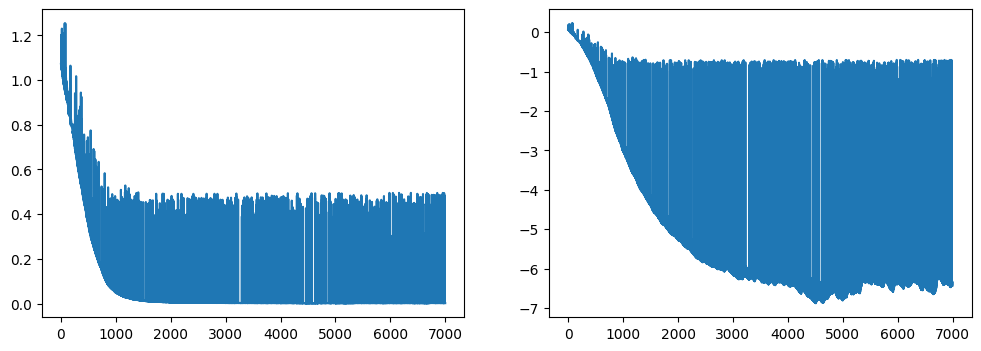

In [186]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Validation and Testing

In [187]:
# Test the model
test_loss = 0
with torch.no_grad():
    for sequence in test_set:
        model_output = model(sequence_tensor)
        test_loss += loss_function(model_output, sequence_tensor).item()
test_loss /= len(test_set)

print("Test loss:", test_loss)


# sample the diffusion model

Test loss: 0.0016072556609287858


### Generate Sample Data

Step: 0, Sample: tensor([-0.1275, -0.1093, -0.0377, -0.1649, -0.1950,  0.2438, -0.1556, -0.1744],
       grad_fn=<TanhBackward0>)
Step: 200, Sample: tensor([-0.9566, -0.9553, -0.9627, -0.9497,  0.9385,  0.9433,  0.9406,  0.9515],
       grad_fn=<TanhBackward0>)
Step: 400, Sample: tensor([-0.9566, -0.9553, -0.9627, -0.9497,  0.9385,  0.9433,  0.9406,  0.9515],
       grad_fn=<TanhBackward0>)
Step: 600, Sample: tensor([-0.9566, -0.9553, -0.9627, -0.9497,  0.9385,  0.9433,  0.9406,  0.9515],
       grad_fn=<TanhBackward0>)
Step: 800, Sample: tensor([-0.9566, -0.9553, -0.9627, -0.9497,  0.9385,  0.9433,  0.9406,  0.9515],
       grad_fn=<TanhBackward0>)
tensor([-0.9566, -0.9553, -0.9627, -0.9497,  0.9385,  0.9433,  0.9406,  0.9515],
       grad_fn=<TanhBackward0>)


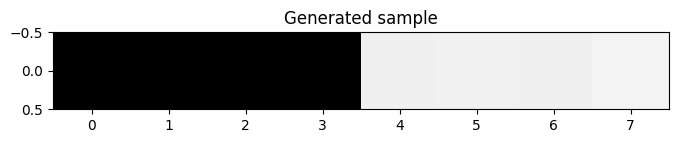

In [208]:
num_steps = 1000  # Number of steps in the reverse process
# Start with noise clipped to [-1, 1]
current_sample = torch.clamp(torch.randn(8), -1, 1).to(device)


for step in range(num_steps):
    # Apply the model to denoise the sample
    denoised_sample = model(current_sample)

    # Update the current sample with the denoised version
    current_sample = denoised_sample
    if step % 200 == 0:
        print(f"Step: {step}, Sample: {current_sample}")

# After the loop, current_sample is your generated sample
generated_sample = current_sample

print(generated_sample)


visualize_sequence(generated_sample.detach().numpy(), title="Generated sample")

#visualize the thresholded sample ()


tensor([ 1.,  1.,  1.,  1., -1., -1., -1., -1.])


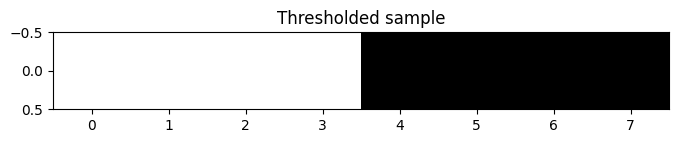

In [189]:
#threshold the sample (to 0 and 1) and visualize it

thresholded_sample = torch.where(generated_sample > 0, torch.ones_like(generated_sample), -torch.ones_like(generated_sample))
print(thresholded_sample)
visualize_sequence(thresholded_sample.detach().numpy(), title="Thresholded sample")